## Train and evaluate model using Scikit-learn and Keras wrapper 

In [1]:
import tensorflow as tf
from aMNWtModel import AMNWtModel
from aMRNNModel import AMRNNModel


model_class = AMRNNModel
model_class = AMNWtModel

seed = 10
# np.random.seed(seed=seed)  
tf.random.set_seed(seed)

# dataset_file = "./Dataset/IJN1463_EXP_UB_Anne.npz"
# objective=['BIOMASS_KT2440_WT3']

# dataset_file = "./Dataset/IJN1463_10_UB.npz"
# objective=['BIOMASS_KT2440_WT3']

# dataset_file = "./Dataset/e_coli_core_UB_100.npz"
# objective=['BIOMASS_Ecoli_core_w_GAM']
# epoch = 200
# batch_size = 7
# uptake_max_index = None

dataset_file = "./Dataset/biolog_iML1515_EXP_UB.npz"
objective=['BIOMASS_Ec_iML1515_core_75p37M']
epoch = 40#20
batch_size = 30
uptake_max_index=151



print("---------------------------------------- model ----------------------------------------")
model = model_class(dataset_file=dataset_file, 
                   objective=objective,
                   timestep=4,
                #    n_hidden=1, 
                   hidden_dim=50,
                   epochs=50, 
                   verbose=True,
                   batch_size=batch_size,
                   uptake_max_index = uptake_max_index)
model.printout()

# Preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler,MaxAbsScaler 
from tools import MaxScaler
scaler= MaxScaler()
model.train_test_split(test_size=0.1, random_state=seed)
# model.preprocess(scaler)
model.preprocessing_for_specific_model()

---------------------------------------- model ----------------------------------------
number of metabolites:  1877
filtered measurements size:  1
dataset file: ./Dataset/biolog_iML1515_EXP_UB.npz
model type: AMNWt
model medium bound: UB
timestep: 4
training set size (17400, 430) (17400, 1)
training epochs: 50
training regression: True
training batch size: 30
training validation iter: 0
training early stopping: False


In [2]:
AMNWt_model = model.build_model()

2023-10-13 10:58:45.885728: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 10:58:45.887223: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
history = AMNWt_model.fit(model.X_train, model.Y_train, epochs=epoch, batch_size=batch_size, verbose=0)

R_2 = model.R2(model.Y_train, AMNWt_model.predict(model.X_train))
Q_2 = model.R2(model.Y_test, AMNWt_model.predict(model.X_test))
print("R2 :", R_2)
print("Q2 :", Q_2)

2023-10-13 10:58:46.989736: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


R2 : 0.7151840565764596
Q2 : 0.7161666025866111


## Regression visualisation

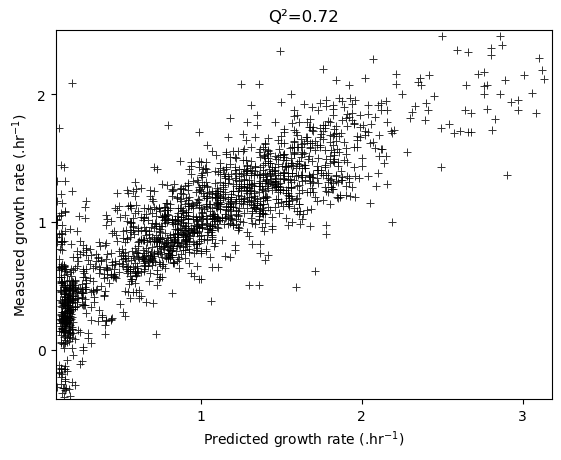

In [4]:
from tools import plot_regression
import numpy as np

TRUE = model.Y_test[:,0]

pred =  AMNWt_model.predict(model.X_test)
P_out     = tf.convert_to_tensor(np.float32(model.P_out))   
PRED = tf.linalg.matmul(pred[:,:model.S.shape[1]], tf.transpose(P_out)) 

plot_regression(PRED, 
                TRUE, 
                "Measured growth rate (."+ r'$\mathregular{hr^{-1}}$' +")",
                "Predicted growth rate (."+ r'$\mathregular{hr^{-1}}$' +")",
                "Q²="+str(round(Q_2, 2)),
                # "Figure/biolog_iML1515_EXP_UB_AMNWt_" + str(epoch) +"_"+ str(batch_size) +"_regression.png")


## Classification visualisation

In [5]:
import numpy as np

TRUE = model.Y_test[:,0]

pred =  AMNWt_model.predict(model.X_test)
P_out     = tf.convert_to_tensor(np.float32(model.P_out))   
PRED = tf.linalg.matmul(pred[:,:model.S.shape[1]], tf.transpose(P_out)) 

true = model.Y_test[:,0]
max = true.max()
percentage = 0.05
cat_true = true >= max*percentage
TRUE =  cat_true.astype(int)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


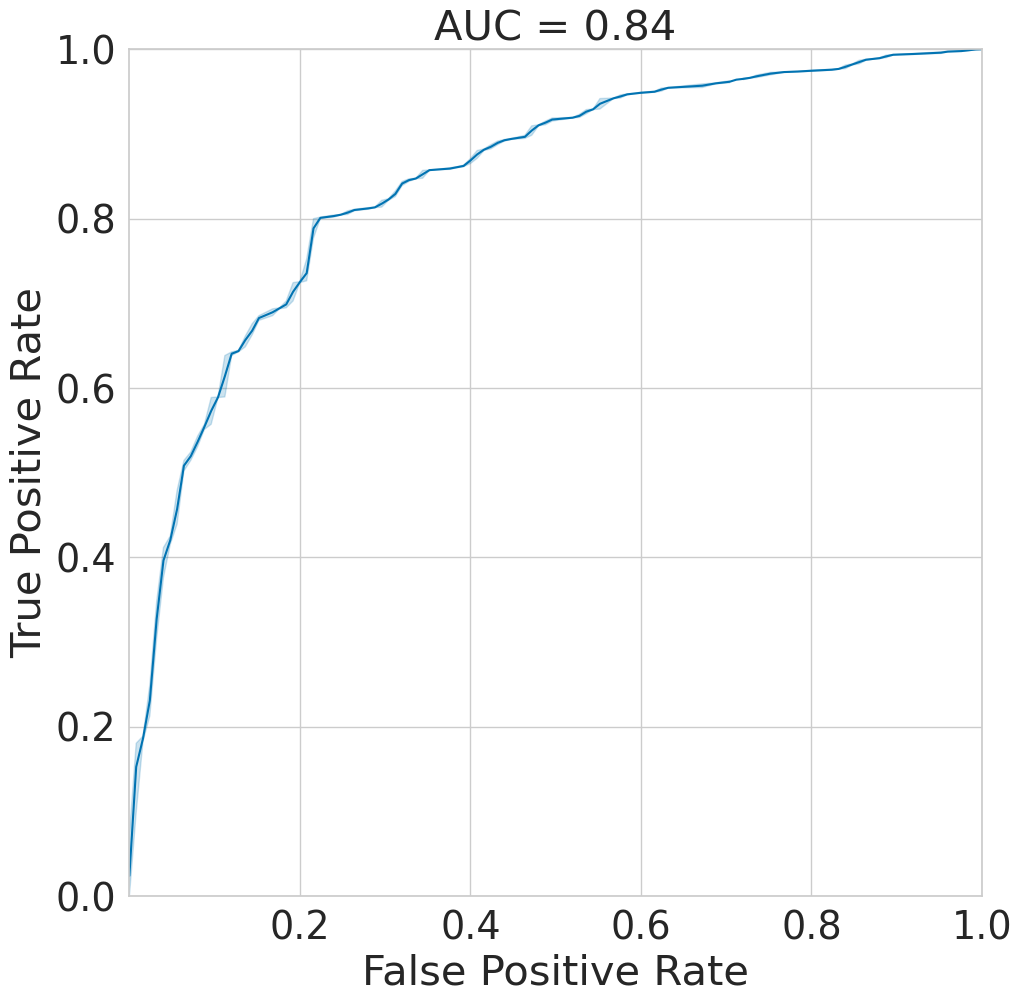

In [6]:
from tools import plot_classification

plot_classification(PRED, 
                    TRUE,
                    # "Figure/biolog_iML1515_EXP_UB_AMNWt_" + str(epoch) +"_"+ str(batch_size) +"_classification.png"
                    )